In [18]:
import cv2
import numpy as np
from pdf2image import convert_from_path
from IPython.display import display, Image
import matplotlib.pyplot as plt

In [19]:
pdf_path = "src/algebra_graph/part5_ideals.pdf"  # Replace with your PDF file path
images = convert_from_path(pdf_path)
if not images:
    raise ValueError("No pages found in the PDF.")

In [20]:
def process_contours(contours, vertical_gap_threshold=20):
    # First pass: Combine contours with small vertical gaps
    combined_contours = []
    prev_contour = None
    
    # Sort contours by y-position (top to bottom)
    sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
    
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        current_rect = (x, y, w, h)
        
        if prev_contour is None:
            prev_contour = current_rect
            combined_contours.append(contour)
            continue
            
        px, py, pw, ph = prev_contour
        # Check vertical gap between current and previous contour
        vertical_gap = y - (py + ph)
        
        if vertical_gap < vertical_gap_threshold:
            # Combine with previous contour
            new_x = min(px, x)
            new_y = min(py, y)
            new_w = max(px + pw, x + w) - new_x
            new_h = max(py + ph, y + h) - new_y
            prev_contour = (new_x, new_y, new_w, new_h)
            # Replace last contour with combined version
            combined_contours[-1] = np.array([[new_x, new_y], 
                                            [new_x + new_w, new_y],
                                            [new_x + new_w, new_y + new_h],
                                            [new_x, new_y + new_h]])
        else:
            prev_contour = current_rect
            combined_contours.append(contour)
    
    # Second pass: Remove contours contained within larger contours
    final_contours = []
    bounding_rects = [cv2.boundingRect(c) for c in combined_contours]
    
    for i, (x1, y1, w1, h1) in enumerate(bounding_rects):
        is_inside = False
        for j, (x2, y2, w2, h2) in enumerate(bounding_rects):
            if i == j:
                continue
            # Check if contour i is completely inside contour j
            if (x1 >= x2 and y1 >= y2 and 
                x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2):
                is_inside = True
                break
                
        if not is_inside:
            final_contours.append(combined_contours[i])
    
    return final_contours

In [21]:
def find_large_contours(image, left_region_ratio=0.25):
    bottom_crop = 0.10

    image_arr = np.array(image)[:int((1 - bottom_crop) * image.height)]
    height, width = image_arr.shape[:2]

    left_width = int(width * left_region_ratio)
    left_region = image_arr[:, :left_width]
    # blurred_left = cv2.erode(left_region, (15, 15), iterations=1)
    blurred_left = cv2.stackBlur(left_region, (21, 21))

    gray_blurred = cv2.cvtColor(blurred_left, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_blurred, 250, 255, cv2.THRESH_BINARY_INV) # 250 to filter white vs. non-white pixels
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours  = process_contours(contours, vertical_gap_threshold=40)

    large_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 100:  # Filter small noise
            large_contours.append((y, h))

    return large_contours

In [22]:
def find_optimal_vertical_line(boxes, large_contours, edge_margin=50):
    if not boxes:
        return None

    # Avoid edges (candidate x must be within box bounds ± margin)
    min_x = min(box[0] for box in boxes) + edge_margin
    max_x = max(box[0] + box[2] for box in boxes) - edge_margin

    if min_x >= max_x:
        return None  # No valid region

    # Generate candidate x-coordinates (every 1 pixel for precision)
    candidate_xs = np.arange(min_x, max_x, 1)
    best_x = None
    min_intersections = float('inf')

    for x in candidate_xs:
        intersections = 0
        for (bx, by, bw, bh) in boxes:
            # Skip boxes that overlap with large contours
            overlaps_large_contour = False
            for (lc_y, lc_h) in large_contours:
                if (by < lc_y + lc_h) and (by + bh > lc_y):
                    overlaps_large_contour = True
                    break
            
            if not overlaps_large_contour and bx <= x <= bx + bw:
                intersections += 1
        
        if intersections < min_intersections:
            min_intersections = intersections
            best_x = x
            if min_intersections == 0:  # Early exit if perfect line found
                break

    return best_x

In [23]:
# def find_optimal_vertical_line(boxes, edge_margin=50):
#     if not boxes:
#         return None

#     # Avoid edges (candidate x must be within box bounds ± margin)
#     min_x = min(box[0] for box in boxes) + edge_margin
#     max_x = max(box[0] + box[2] for box in boxes) - edge_margin

#     if min_x >= max_x:
#         return None  # No valid region

#     # Generate candidate x-coordinates (every 5 pixels for efficiency)
#     candidate_xs = np.arange(min_x, max_x, 1)
#     best_x = None
#     min_intersections = float('inf')

#     for x in candidate_xs:
#         intersections = 0
#         for (bx, by, bw, bh) in boxes:
#             if bx <= x <= bx + bw:  # Line intersects this box
#                 intersections += 1
#         if intersections < min_intersections:
#             min_intersections = intersections
#             best_x = x
#             if min_intersections == 0:  # Early exit if perfect line found
#                 break

#     return best_x

def process_page(image, bottom_crop=0.10, min_width=75, kernel_k=3):
    image_arr = np.array(image)[:int((1 - bottom_crop) * image.height)]

    image_rgb = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((kernel_k, kernel_k), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    large_contours = find_large_contours(image)

    boxes = []
    all_contours = []  # Store all valid contours (including those near large contours)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > min_width and h > 20:  # Filter small noise
            all_contours.append((x, y, w, h))
            # Only add to boxes if not near large contours
            near_large_contour = False
            for (lc_y, lc_h) in large_contours:
                if (y < lc_y + lc_h) and (y + h > lc_y):  # Y-range overlap check
                    near_large_contour = True
                    break
            if not near_large_contour:
                boxes.append((x, y, w, h))

    # all_contours = sort_contours(all_contours)

    # Find optimal line using filtered boxes
    optimal_x = find_optimal_vertical_line(boxes, large_contours)

    # Visualization
    for idx, (x, y, w, h) in enumerate(all_contours):
        # Check if this box was excluded due to large contours
        excluded = False
        for (lc_y, lc_h) in large_contours:
            if (y < lc_y + lc_h) and (y + h > lc_y):
                excluded = True
                break
        
        if excluded:
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red for excluded
        else:
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green for included

        text = str(idx)
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        text_x = x + (w - text_size[0]) // 2
        text_y = y + (h + text_size[1]) // 2
        cv2.putText(image_rgb, text, (text_x, text_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 5)

    # Draw optimal line if found
    if optimal_x is not None:
        cv2.line(image_rgb, (optimal_x, 0), (optimal_x, image_rgb.shape[0]), (255, 0, 0), 2)

    left_margin_per = 0.25
    cv2.line(image_rgb, (round(image_rgb.shape[1] * left_margin_per), 0), (round(image_rgb.shape[1] * left_margin_per), image_rgb.shape[0]), (0, 0, 255), 2)

    return image_rgb

In [24]:
def plot_pdf_pages_grid(images, N=6, k=2):
    N = min(N, len(images)) # check to prevent index overbound 
    rows = max((N // k) + (N % k != 0), 1) # just in case (probably not necessary)
    
    _, axes = plt.subplots(rows, k, figsize=(9, 16)) # figsize=(15, 10 * rows / k)
    axes = axes.ravel().flatten() if rows > 1 else axes
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"Page {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

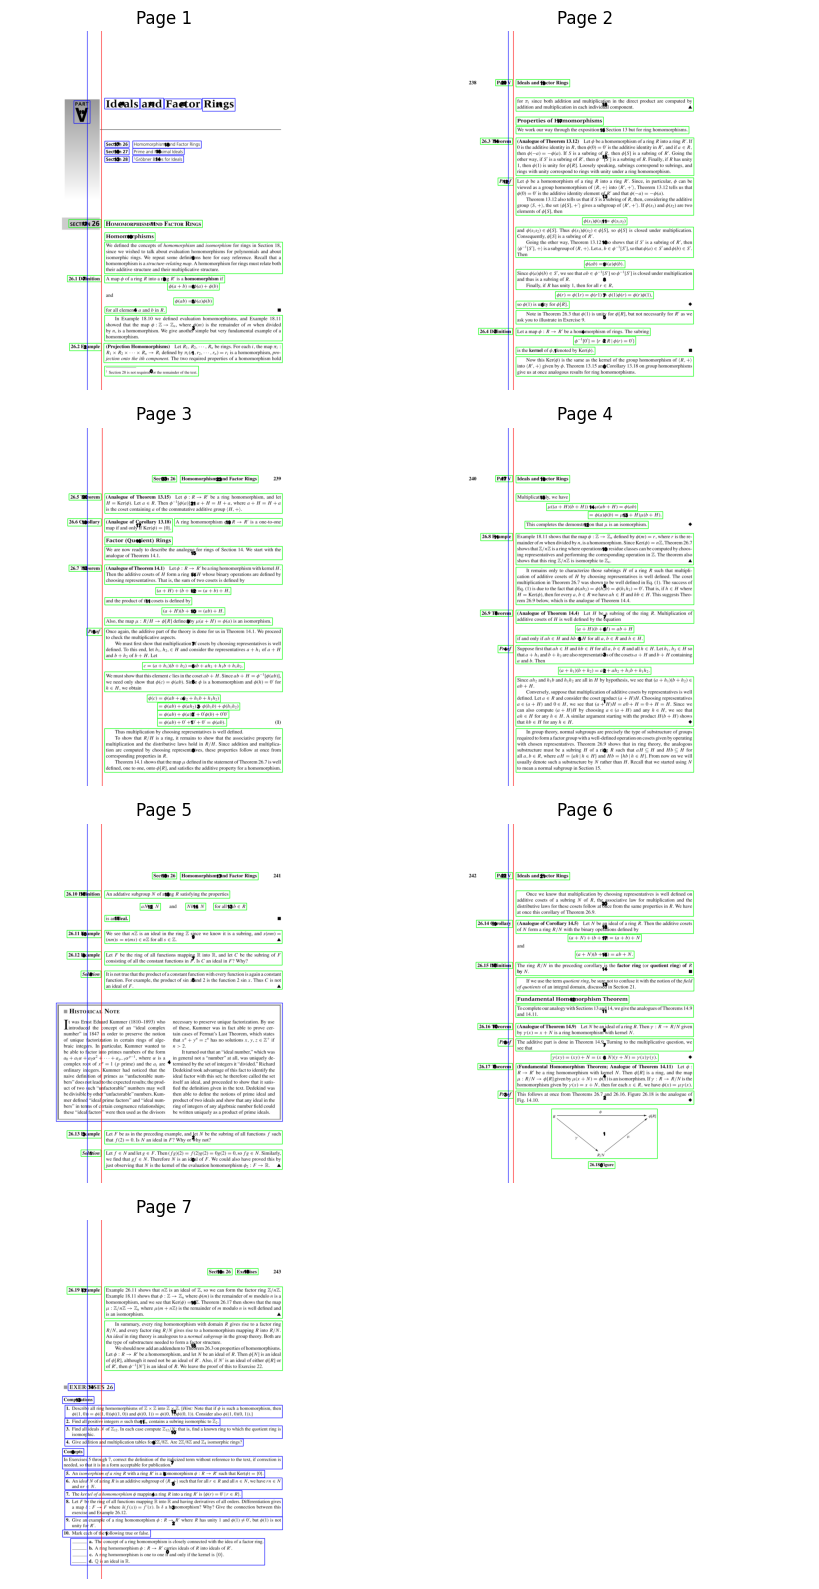

In [25]:
processed_images = [process_page(img, kernel_k=9) for img in images]

plot_pdf_pages_grid(processed_images, N=100, k=2)

In [26]:
def sort_contours(contours):
    """Sort contours in reading order (left-to-right, top-to-bottom).
    Args:
        contours: List of contours as (x, y, w, h) tuples
    Returns:
        List of contours sorted in reading order
    """
    # First sort by y-coordinate (top-to-bottom)
    contours_sorted_y = sorted(contours, key=lambda c: (c[1], c[0]))
    
    # Then group by similar y-coordinates (same line) and sort each group by x (left-to-right)
    sorted_contours = []
    current_line_y = None
    current_line = []
    
    for contour in contours_sorted_y:
        x, y, w, h = contour
        if current_line_y is None or abs(y - current_line_y) < h * 0.5:  # Considered same line
            current_line.append(contour)
            current_line_y = y if current_line_y is None else current_line_y
        else:
            # Sort the completed line left-to-right
            sorted_contours.extend(sorted(current_line, key=lambda c: c[0]))
            current_line = [contour]
            current_line_y = y
    
    # Add the last line
    if current_line:
        sorted_contours.extend(sorted(current_line, key=lambda c: c[0]))
    
    return sorted_contours

In [27]:
from collections import OrderedDict

def process_page(image, bottom_crop=0.10, min_width=75, kernel_k=3):
    image_arr = np.array(image)[:int((1 - bottom_crop) * image.height)]

    image_rgb = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((kernel_k, kernel_k), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    large_contours = find_large_contours(image)

    boxes = []
    all_contours = []  # Store all valid contours (including those near large contours)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > min_width and h > 20:  # Filter small noise
            all_contours.append((x, y, w, h))
            # Only add to boxes if not near large contours
            near_large_contour = False
            for (lc_y, lc_h) in large_contours:
                if (y < lc_y + lc_h) and (y + h > lc_y):  # Y-range overlap check
                    near_large_contour = True
                    break
            if not near_large_contour:
                boxes.append((x, y, w, h))

    # all_contours = sort_contours(all_contours)

    all_contours.sort(key=lambda x: x[1] * 10e5 + x[0])

    optimal_x = find_optimal_vertical_line(boxes, large_contours)
    # if optimal_x is not None:
    #     cv2.line(image_rgb, (optimal_x, 0), (optimal_x, image_rgb.shape[0]), (255, 0, 0), 2)
    assert optimal_x is not None, 'No optimal line found'
    if type(optimal_x) != int:
        optimal_x = optimal_x.item()

    # contour_pairs = {} # assumes the contours are ordered
    contour_pairs = OrderedDict()

    for i, (x, y, w, h) in enumerate(all_contours):
        excluded = False
        for (lc_y, lc_h) in large_contours:
            if (y < lc_y + lc_h) and (y + h > lc_y):
                excluded = True
                break
        
        if not excluded:

            if x + h <= optimal_x:
                contour_pairs[(x, y, w, h)] = (optimal_x, y + h, optimal_x, y + h)

            else:
                print(i ,contour_pairs, x, x + h, optimal_x)

                last_contour_key = list(contour_pairs.keys())[-1]
                last_contour_value = contour_pairs[last_contour_key]
                new_contour_value = (min(x, last_contour_value[0]), min(y, last_contour_value[1]), 
                                     max(x + w, last_contour_value[2]), max(y + h, last_contour_value[3]))

                contour_pairs[last_contour_key] = new_contour_value
            # cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Red for excluded

    for k, v in contour_pairs.items():
        cv2.rectangle(image_rgb, (k[0], k[1]), (k[0] + k[2], k[1] + k[3]), (0, 255, 0), 2)
        cv2.rectangle(image_rgb, (v[0], v[1]), (v[2], v[3]), (0, 0, 255), 2)

    return image_rgb

1 OrderedDict({(355, 267, 93, 35): (453, 302, 453, 302)}) 467 508 453
2 OrderedDict({(355, 267, 93, 35): (453, 267, 763, 308)}) 467 608 453
4 OrderedDict({(355, 267, 93, 35): (453, 267, 1444, 509), (249, 530, 199, 41): (453, 571, 453, 571)}) 467 541 453
5 OrderedDict({(355, 267, 93, 35): (453, 267, 1444, 509), (249, 530, 199, 41): (453, 530, 1444, 604)}) 753 793 453
6 OrderedDict({(355, 267, 93, 35): (453, 267, 1444, 509), (249, 530, 199, 41): (453, 530, 1444, 649)}) 793 833 453
8 OrderedDict({(355, 267, 93, 35): (453, 267, 1444, 509), (249, 530, 199, 41): (453, 530, 1444, 740), (247, 762, 201, 35): (453, 797, 453, 797)}) 466 540 453
9 OrderedDict({(355, 267, 93, 35): (453, 267, 1444, 509), (249, 530, 199, 41): (453, 530, 1444, 740), (247, 762, 201, 35): (453, 762, 1444, 836)}) 467 541 453
10 OrderedDict({(355, 267, 93, 35): (453, 267, 1444, 509), (249, 530, 199, 41): (453, 530, 1444, 740), (247, 762, 201, 35): (453, 762, 1446, 921)}) 467 512 453
11 OrderedDict({(355, 267, 93, 35): (45

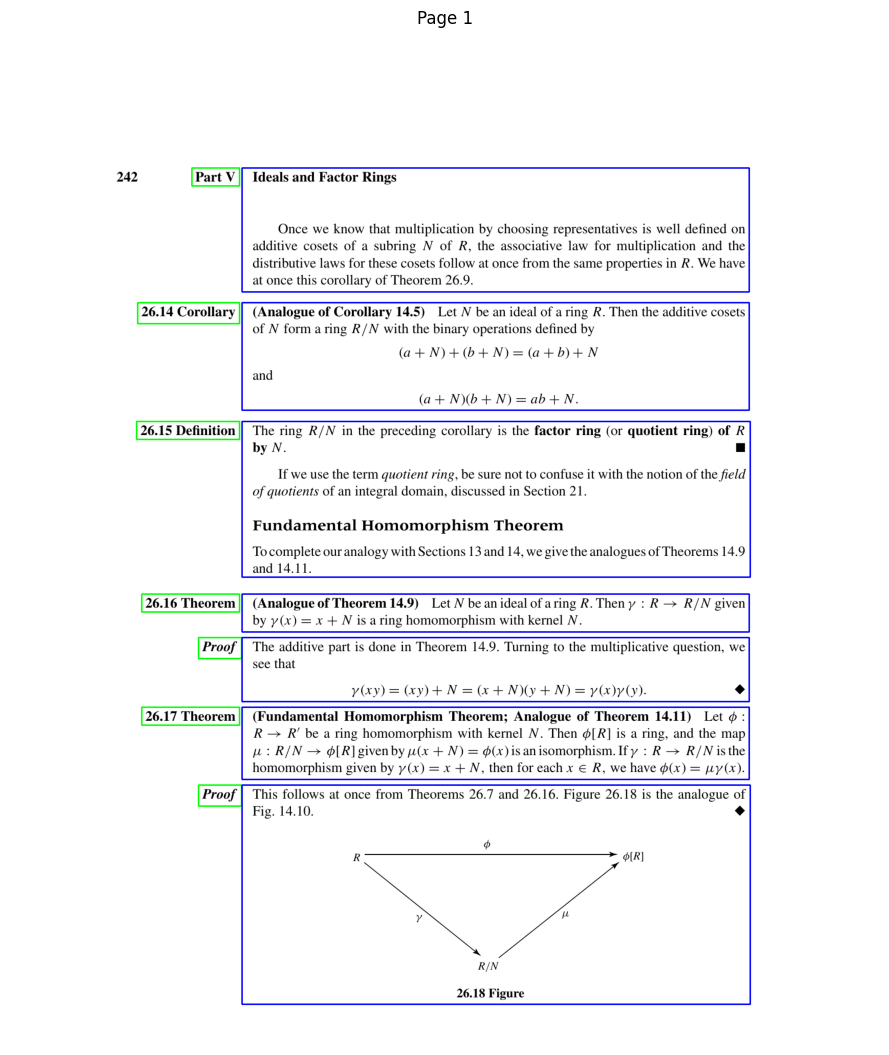

In [28]:
def plot_pdf_pages_grid(images, N=6, k=2):
    N = min(N, len(images)) # check to prevent index overbound 
    rows = max((N // k) + (N % k != 0), 1) # just in case (probably not necessary)
    
    _, axes = plt.subplots(rows, k, figsize=(9, 16)) # figsize=(15, 10 * rows / k)
    axes = axes.ravel().flatten() if rows > 1 else [axes]
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"Page {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_pdf_pages_grid([process_page(images[5], kernel_k=9)], N=100, k=1)

In [ ]:
plot_pdf_pages_grid([process_page(images[2], kernel_k=9)], N=100, k=1)

0 OrderedDict() 782 818 507


IndexError: list index out of range

In [ ]:
processed_images = [process_page(img, kernel_k=9) for img in images]

plot_pdf_pages_grid(processed_images, N=100, k=2)

12 OrderedDict({(323, 1039, 177, 45): (503, 1084, 503, 1084)}) 519 560 503
13 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1058, 1084)}) 521 566 503
14 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1058, 1157)}) 520 694 503
15 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1499, 1338)}) 520 562 503
17 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1499, 1389), (315, 1348, 187, 35): (503, 1383, 503, 1383)}) 866 906 503
18 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1499, 1389), (315, 1348, 187, 35): (503, 1383, 1151, 1429)}) 900 940 503
19 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1499, 1389), (315, 1348, 187, 35): (503, 1383, 1151, 1511)}) 521 556 503
20 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1499, 1389), (315, 1348, 187, 35): (503, 1383, 1151, 1556)}) 520 661 503
22 OrderedDict({(323, 1039, 177, 45): (503, 1043, 1499, 1389), (315, 1348, 187, 35): (503, 1383, 1499, 1709), (327, 1722, 175, 41): (503, 1763, 503, 1763)}) 516 623 503
23 OrderedDict({(323, 1039, 177, 45):

IndexError: list index out of range